# Dark Matter Galactic Centre annihilation limits from CTA

Here we calculate the limits of the CTA telescope to dark matter annihilation from the galactic centre using the Equivalent Counts (EC) method which uses the Fisher Information matrix for experimental projections. The EC method is implemented through the swordfish package

In [1]:
from __future__ import division
import healpy as hp
import numpy as np
import pylab as plt
import swordfish as sf
from scipy.interpolate import interp1d
from scipy.integrate import quad
from math import cos, sin
from matplotlib import rc
import metricplot as mp
from swordfish import Ronald as ron

rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})
%matplotlib inline

We now want to implement the dark matter signal as so,  

$$ \frac{dN}{d\Omega} = \frac{\langle \sigma v \rangle}{8 \pi m^2} \frac{dN}{dE} J\left(\Omega\right)$$

where $J(\Omega)$ is the astrophysical J factor and the rest of the expression represent the particle physics. We define the signal coming from the galactic centre with line of sight integrals through an NFW 

We now want to calculate the signal from the galactic halo in the form of a Jfactor map. For simplicity here we simply use a map of 10 deg $\times$ 10 deg around the galactic centre

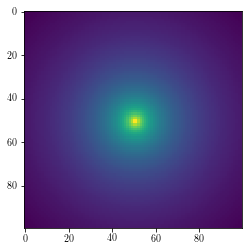

In [2]:
def get_los():
    # Define DM profile
    MW_D = 8.5 # kpc
    MW_rs = 20 # kpc
    alpha = 0.17
    MW_rhoS = 0.122 # GeV cm^-3 (local density of 0.3 GeV/cm3)
    kpc_cm = 3.086e21 # kpc/cm
    def Lum_los(d, l, b):
        """Returns density squared for given galactic coordinates l and b at 
        distance d away from Suns location"""
        l = np.deg2rad(l)
        b = np.deg2rad(b)
        if (MW_D**2. + d**2. - (2*MW_D*d*cos(b)*cos(l))) < 0.0:
            R = 1e-5
        else:
            R = np.sqrt(MW_D**2. + d**2. - (2*MW_D*d*cos(b)*cos(l)))
        if R < 1e-5:
            R = 1e-5
        ratio = R/MW_rs
        rho_dm = MW_rhoS*np.exp(-(2/alpha)*((ratio)**alpha - 1))
        return rho_dm**2.
    l = np.logspace(-3,np.log10(180),num=50)
    los = np.zeros(len(l))
    for i in range(len(l)):
        los[i] = quad(Lum_los,0.,30.,args=(l[i],0.0))[0]*kpc_cm
    Interp_sig = interp1d(l,los, bounds_error=False, fill_value=los[0])
    return Interp_sig

def get_Jmap(resolution):
    # Enter the resolution in number of pixels
    # Jmap constructs a grid of 10 degress by degrees around the galactic center
    n_pix = int(resolution/10)
    Interp_sig = get_los()
    center = (n_pix/2)+0.5
    Jmap = np.zeros([n_pix,n_pix])
    pixel_rad = 10./n_pix/2.
    for i in range(0,n_pix):
        for j in range(0,n_pix):
            l = np.arctan(pixel_rad*np.sqrt((i-center)**2 + (j-center)**2)/8.5)
            Jmap[i,j] = Interp_sig(l)
    return Jmap

DM_sig = get_Jmap(1000)
plt.imshow(DM_sig)
plt.show()

We now want to describe the main backgrounds which come from cosmic ray electrons and protons. The spectra of the electon and proton backgrounds are described as a broken power law and power law respectively. We take the values from 1408.4131.

In [3]:
E = np.logspace(1.0, 3.0, num=50)
Ewidth = np.diff(E)
Emeans = E[0:-1]+Ewidth/2.

def dNdE_e(E):
    """Cosmic-ray electron flux, 1/GeV cm2 s sr."""
    # Silverwood et al.
    E0 = 1e3
    return 1.17e-11*np.where(E > E0, (E/E0)**-3.9, (E/E0)**-3.0)

def dNdE_p(E):
    """Cosmic-ray proton flux, 1/GeV cm2 s sr."""
    # Factor of 3 accounts for approximate expected shift in energy
    # reconstruction, see Silverwood et al.
    return 8.73e-9*(E*3/1e3)**-2.71

def get_instr_bkg(E):
    """Crude estimation of instrumental background.  Return square map"""
    CR_Elec_bkg = dNdE_e(Emeans)*Ewidth
    proton_eff = 1e-2  # Assumed flat proton efficiency
    CR_Proton_bkg = proton_eff*dNdE_p(Emeans)*Ewidth
    spec_bkg = CR_Proton_bkg + CR_Elec_bkg
    CR_e = np.full((DM_sig.shape[0],DM_sig.shape[0],len(Emeans)), CR_Proton_bkg)
    CR_p = np.full((DM_sig.shape[0],DM_sig.shape[0],len(Emeans)), CR_Elec_bkg)
    return CR_e, CR_p

Finally we need to define the spectrum of the signal component for which we will use a basic analytic approximation as,

$$ \frac{dN}{dE} \propto E^{-1.5}e^{-E/E_{cut}}$$

where we define the normalisation as,

$$ A\int dE\frac{dN}{dE}E = 2m_{DM}$$

In [4]:
def get_sig_spec(m):
    def spec_DM(m):
        spectrum = lambda x: x**(-1.5)*np.exp(-x/30.)
        specnorm = lambda y: y*spectrum(y)
        norm = 2*m/quad(specnorm,E[0],E[-1])[0]
        return spectrum(Emeans)*norm
#     plt.loglog(Emeans,spec_DM(10))
#     plt.show()
    return spec_DM(m)*Ewidth/8/np.pi/m**2
# get_sig_spec(5)

We will also now define the exposure in terms of a square map

In [5]:
def get_exposure(E, Tobs):
    """Generate exposure table, based on observation time.  Return HARPix map."""
    # Effective area taken from 
    # https://portal.cta-observatory.org/CTA_Observatory/performance/SiteAssets/SitePages/Home/PPP-South-EffectiveAreaNoDirectionCut.png
    Et, EffA = np.loadtxt("../data/CTA_effective_A.txt", unpack=True)
    Et *= 1e3  # TeV --> GeV
    EffA *= 1e4  # m2 --> cm2
    EffectiveA_cm2 = interp1d(Et, EffA, fill_value="extrapolate")(Emeans)
    obsT = Tobs*3600  # h --> s
    expotab = obsT*EffectiveA_cm2  # Exposure in cm2 s  (Aeff * Tobs)
    return np.full((DM_sig.shape[0],DM_sig.shape[0],len(Emeans)), expotab)

Finally we want to define our covariance matrix

In [6]:
def get_sigma(x, f):
    X, Y = np.meshgrid(x,x)
    Sigma = f(X,Y)
    A = 1/np.sqrt(np.diag(Sigma))
    Sigma = np.diag(A).dot(Sigma).dot(np.diag(A))
    return Sigma

In [23]:
def CTA(m_DM, syst_flag = True, Tobs = 100., Skymap = False):
    # Parameters
    unc = 0.01 # 1% bkg uncertainty
    corr_length = 1  # 10 deg correlation length of bkg uncertainty
    sv0 = 1e-26

    # Get signal
    Spec = get_sig_spec(m_DM)*sv0
    S = np.einsum('ij,k->ijk', DM_sig, Spec)
    
    # Get background (instr.)
    B1, B2 = get_instr_bkg(E)  # FIXME?

    # Covariance
#     Sigma = get_sigma(B1, lambda x, y: np.exp(-(x-y)**2/2/(x*y)/0.5**2))

    # Get exposure
    expo = get_exposure(E, Tobs)
    
    # Define ronald Object
    alpha = 0.05
    r = ron([B1, B2], T=[0.1,0.], E=expo, K=None)
    x_UL = r.upperlimit(S, alpha)
    sv_UL = x_UL*sv0

    return sv_UL

Finally lets make a limit plot with streamlines to show the density of models in the paramter space

Mass [GeV] 31.6227766017
Upper limit [cm3/s]: 6.11786523845e-33
Mass [GeV] 35.6224789026
Upper limit [cm3/s]: 6.89166318729e-33
Mass [GeV] 40.1280703194
Upper limit [cm3/s]: 7.76333241022e-33
Mass [GeV] 45.2035365636
Upper limit [cm3/s]: 8.74525183164e-33
Mass [GeV] 50.9209563677
Upper limit [cm3/s]: 9.85136608321e-33
Mass [GeV] 57.3615251045
Upper limit [cm3/s]: 1.10973835372e-32
Mass [GeV] 64.6167078747
Upper limit [cm3/s]: 1.25009993875e-32
Mass [GeV] 72.7895384398
Upper limit [cm3/s]: 1.40821469459e-32
Mass [GeV] 81.996082446
Upper limit [cm3/s]: 1.58632807234e-32
Mass [GeV] 92.3670857187
Upper limit [cm3/s]: 1.78696953153e-32
Mass [GeV] 104.049831037
Upper limit [cm3/s]: 2.01298846203e-32
Mass [GeV] 117.210229753
Upper limit [cm3/s]: 2.26759464936e-32
Mass [GeV] 132.035177972
Upper limit [cm3/s]: 2.55440385814e-32
Mass [GeV] 148.735210729
Upper limit [cm3/s]: 2.87748918103e-32
Mass [GeV] 167.547491892
Upper limit [cm3/s]: 3.24143888232e-32
Mass [GeV] 188.739182214
Upper limit [cm3

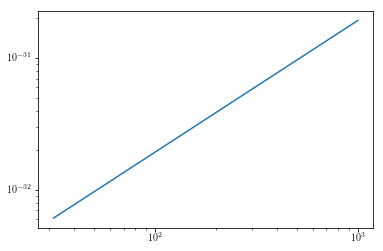

In [24]:
mlist = np.logspace(1.5, 3.0, 30)
svlist = np.logspace(-27, -24, 31)
ULlist = []
G = np.zeros((len(svlist), len(mlist),2,2))
for i, m in enumerate(mlist):
    UL = CTA(m, syst_flag = True)
    print "Mass [GeV]", m
    print "Upper limit [cm3/s]:", UL
    ULlist.append(UL)
    
plt.loglog(mlist,ULlist)
plt.show()

We can now visualise the information content of the sky by looking at the information flux distributed over the sky at different exposures for a dark mass of 50 GeV

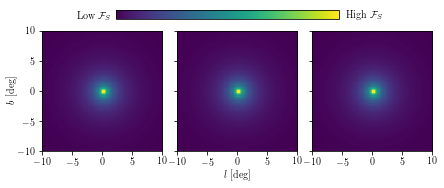

In [160]:
# Get the signal and backgrounds for a 50 GeV Dark matter particle
sv0 = 1e-26
Spec = get_sig_spec(50)*sv0
S = np.einsum('ij,k->ijk', DM_sig, Spec)
B1, B2 = get_instr_bkg(E)
# Sigma = get_sigma(B1, lambda x, y: np.exp(-(x-y)**2/2/(x*y)/0.5**2))

plt.figure(figsize=(4,3))
fig, axes = plt.subplots(nrows=3, ncols=1)

for i, s in enumerate(np.logspace(0,3,num=3)):
    plot = '13' + str(i+1)
    ax = plt.subplot(plot)
    expo = get_exposure(E, s)
    r = ron([B1, B2], T=[0.1,0.], E=expo, K=None)
    InfofluxMap = r.infoflux(S).sum(axis=2)
    if i != 0:
        ax.set_yticklabels([])
    im = ax.imshow(InfofluxMap, extent=[-10,10,-10,10])
    if i == 1:
        ax.set_xlabel(r"$l$ [deg]")
    if i == 0:    
        ax.set_ylabel(r"$b$ [deg]", labelpad=0.1)


plt.draw()
p0 = axes[0].get_position().get_points().flatten()
p1 = axes[1].get_position().get_points().flatten()
p2 = axes[2].get_position().get_points().flatten()
fudge = 1.5
width = (p1[2]-p0[0])/fudge
width_diff = (p1[2]-p0[0]) - width
start = p0[0]+width_diff/2
ax_cbar = fig.add_axes([start, 0.75, width, 0.03])
plt.colorbar(im, cax=ax_cbar, ticks=[],orientation='horizontal')
ax_cbar.text(-0.1, -0.3, r'Low $\mathcal{F}_S$', transform=ax_cbar.transAxes, 
    va='bottom', ha='center')
ax_cbar.text(1.11, -0.3, r'High $\mathcal{F}_S$', transform=ax_cbar.transAxes, 
    va='bottom', ha='center')
plt.tight_layout(pad=0.1)
plt.savefig("Infoflux_skymap.eps", dpi=200, bbox_inches="tight")